<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Assignment 11</center><h2>

**Instructor** : Dr. C. Lee Giles <br>
**TA** : Neisarg Dave, Shaurya Rohatgi
<br><br>

Credits: 

<h3>Course Policy<h3>

Carefully read all the instructions, before you start working on the assignment

* Give maximum explanation for each sub-problems.

* Please avoid single line answers, submissions without any explanations would receive 0 points.

* Late submissions will be graded with 20% discount per day. Day 1 starts immediately after the submission deadline.

* Every assignment has a hard deadline, usually 3 days past the original due date.

* Late submissions (penalty or not) are not accepted after the hard deadline.

* All source materials must be cited. The University Academic Code of Conduct will be strictly enforced.

* We will be creating Canvas submission page for this. Submit all files on Canvas.

* All queries related to Assignment should have a subject line *IST597:Assignment_11 Queries*

---


<h2><center>Convolution Neural Networks</center></h2>

---

#### What is Convolution

3Blue1Brown explains it best:

https://www.youtube.com/watch?v=KuXjwB4LzSA

In practice, especially for images, instead of performing convolution, we perform cross correlation operation (and call it Convolution !!)

What is the difference?
Cross correlation is performing colvolution, but without inverting the kernel function. 

https://en.wikipedia.org/wiki/Cross-correlation

<br>

#### Learnable Convolution Kernels

Convolution Neural Networks are composed of multiple layers of cross-correlation operators with learnable kernels.

<br>

#### Max Pooling

Max pooling is a pooling technique where we select the max value from the image masked by the max pooling kernel. We then slide this kernel across our image, resulting in a smaller image. 

https://www.youtube.com/watch?v=ZjM_XQa5s6s

<br>

#### Conv Layers in PyToch
We will use 2D conv layers and max pool layers from PyTorch to create our model

+ https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
+ https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

---



This assignment has 3 tasks:
1. Training a ConvNet on CIFAR10 dataset
2. Data Augmentation 
3. Adversarial Samples

You can change your model hyperparameters for task 1, keep the model structure same for tasks 2 and 3

You can use inbuilt torch or sklearn functionalities wherever possible.

Provide detailed explaination for each observation.


In [1]:
import torch
import random
import gc
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from statistics import mean
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from torchvision.transforms import Compose
import collections
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
import pprint
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)
np.set_printoptions(suppress=True)

In [2]:
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)
print(len(train_dataset))
val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000
40000 10000 10000


In [3]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

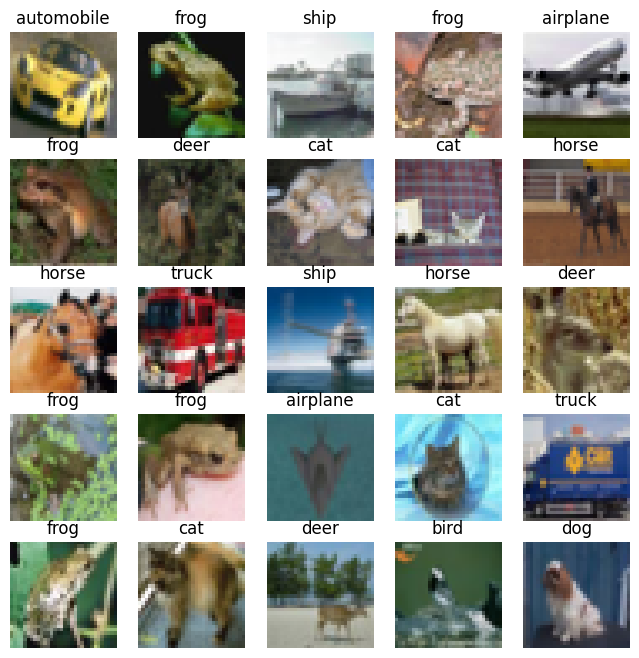

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

## Task 1
Train a decently fit (no underfitting or overfitting) neural network on the CIFAR 10 dataset. 
+ Keep track of your validation loss to select the best model
+ You are free to change network hyperparameters and batch size
+ You are free to change optimizer settings and loss function
+ Run your model 5 times with different seeds and report mean and standard deviation of the following metrices on Test Set:
  1. Accuracy for each class
  2. Precision for each class
  3. Recall for each class
  4. F1 score for each class
  5. Visualize the Confusion Matrix (use only mean values for this)



In [5]:
## Sample Classification Network

class ConvolutionNeuralNetwork_Task1(torch.nn.Module):
    def __init__(self):
        super(ConvolutionNeuralNetwork_Task1, self).__init__()
        self.conv = torch.nn.Sequential(
          torch.nn.Conv2d(3, 64, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(64, 128, 5),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5)
        )

        self.fc1 = torch.nn.Linear(512, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 10)
  
    def forward(self, data):
        bs = data.shape[0]
#         print(bs)
        data = self.conv(data)
#         print(data.shape)
        data = data.reshape(bs, -1)
#         print(data.shape)
        data = torch.relu(self.fc1(data))
        data = torch.relu(self.fc2(data))
        logits = self.fc3(data)
        return logits

In [6]:
# Metrics functions
def mean_conf_matrix(confused_task1):
    for i in range(len(confused_task1)):
        extract_array = confused_task1[i]
        converted_to_numpy = np.asanyarray(extract_array)
        confused_task1[i] = converted_to_numpy

    mean_confusion_task1 = np.mean(confused_task1, axis=0)
    class_wise_acc = mean_confusion_task1.diagonal()/mean_confusion_task1.sum(axis=0)
    print(mean_confusion_task1)
    i=0
    print(f"\n Classwise Acc:")
    for c in list(class_to_idx.keys()):
        print(f"{c} : {class_wise_acc[i]}")
        i = i + 1

def class_wise(_over_trials):
    classw_mean = [0] * 10
    classw_ = _over_trials
    for c in classw_:
        for d in range(len(c)):
            classw_mean[d] += c[d]
    classwise_ = {}

    e = 0
    for c in list(class_to_idx.keys()):
        classwise_[c] = classw_mean[e]/5
        e = e + 1
    print(classwise_)

In [7]:
# Data
batch_size = 60
train_data = DataLoader(train_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)
test_data = DataLoader(test_dataset, batch_size = batch_size)

In [8]:
# Task 1 Trials
conf_matrix = []
classwise_accuracies = []

# metrics init
f1_over_trials = []
precision_over_trials = []
recall_over_trials = []

# trials loop
for t in range(5):
    total = 0
    correct = 0
    local_class_acc = []

  # init 
    seed = random.randint(100,10000)
    random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    model = ConvolutionNeuralNetwork_Task1().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
  
  # Training
    training_loss = []
    validation_loss = []

  # Validation Flag
    val = False

    for epoch in range(60):
#         print(f"Running Trial {t} epoch {epoch}")
        model.train()
        accuracy = 0.0
        total = 0.0
        correct = 0.0
        train_loss = 0.0
        valid_loss = 0.0
        for i, batch_data in enumerate(train_data):
            data, label_data = batch_data
            data = data.cuda()
            label_data = label_data.cuda()
            predicts = model(data)
            loss = loss_fn(predicts, label_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        training_loss.append(train_loss / len(train_data))

    if val:
        model.eval()
        for i, batch_data in enumerate(val_data):
            data, labels = batch_data
            data = data.cuda()
            labels = labels.cuda()

            with torch.no_grad():
                predicts = model(data)
                loss = loss_fn(predicts, labels)
                valid_loss += loss.item()
                mx_index = torch.argmax(predicts, dim=1)
                total += labels.numel()
                correct += sum(mx_index == labels).item()
        validation_loss.append(valid_loss / len(val_data))
        accuracy = ( correct / total ) * 100
        print(accuracy)

  # Testing
    y_pred = []
    y_true = []
    accuracy = []
    for j, batch_data in enumerate(test_data):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            predicts = model(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total += labels.numel()
            correct += (max_prob == labels).sum().item()
            y_pred = np.hstack((y_pred, max_prob.cpu()))
            y_true = np.hstack((y_true, labels.cpu()))


    accuracy = ( correct / total ) * 100
    print(f"\n Trial {t} Test Accuracy : {accuracy} \n")
    CM = confusion_matrix(y_true, y_pred)
    conf_matrix.append(CM)

#   # classwise accuracies
#     class_accs = {}
#     for idx, cls in enumerate(idx_to_class):
#         true_negatives = np.sum(np.delete(np.delete(CM, idx, axis=0), idx, axis=1))
#         true_positives = CM[idx, idx]
#         class_accs[cls] = (true_positives + true_negatives) / np.sum(CM)
    
#     classwise_accuracies.append(class_accs)
#     print(classwise_accuracies)

    f1_over_trials.append(f1_score(y_true, y_pred, average=None))
    precision_over_trials.append(precision_score(y_true, y_pred, average=None, zero_division=1))
    recall_over_trials.append(recall_score(y_true, y_pred, average=None))


 Trial 0 Test Accuracy : 71.6 


 Trial 1 Test Accuracy : 72.5 


 Trial 2 Test Accuracy : 72.76 


 Trial 3 Test Accuracy : 72.28999999999999 


 Trial 4 Test Accuracy : 72.46000000000001 



In [9]:
confused_task1 = conf_matrix
classw_acc = classwise_accuracies
print("Classwise f1:")
class_wise(f1_over_trials)
print("\n Classwise precision:")
class_wise(precision_over_trials)
print("\n Classwise recall:")
class_wise(recall_over_trials)
print("\n Confusion Matrix:")
mean_conf_matrix(confused_task1)

Classwise f1:
{'airplane': 0.7428291935713442, 'automobile': 0.8379566773348636, 'bird': 0.6311311490315277, 'cat': 0.5219792198413599, 'deer': 0.6907811422247365, 'dog': 0.6195810568267442, 'frog': 0.7936715864613033, 'horse': 0.7725002606570812, 'ship': 0.8216971316315682, 'truck': 0.8030901292233494}

 Classwise precision:
{'airplane': 0.754116057884436, 'automobile': 0.8492478429889877, 'bird': 0.6016229328094864, 'cat': 0.544190674073721, 'deer': 0.6722868930283823, 'dog': 0.6296269735965556, 'frog': 0.7855442591919398, 'horse': 0.7807369860095729, 'ship': 0.8679175308511958, 'truck': 0.7904609035002237}

 Classwise recall:
{'airplane': 0.7346, 'automobile': 0.8276, 'bird': 0.6664, 'cat': 0.5032, 'deer': 0.7128, 'dog': 0.618, 'frog': 0.8044, 'horse': 0.7656000000000001, 'ship': 0.7818, 'truck': 0.8177999999999999}

 Confusion Matrix:
[[734.6  23.   80.   22.6  28.2   6.   10.    9.8  49.2  36.6]
 [ 21.  827.6  15.4   7.2   3.2   7.2  13.4   4.   18.4  82.6]
 [ 48.6   3.4 666.4  55

### In this task: Finding a good fit model
1. Mean Accuracy achieved is approx. 72% over 60 epochs
2. Added dropout layers for regualrization and reduced learning rate from 0.01 to 0.005 to increase base accuracy of 63% to 72%

## Task 2: Data Augmentation

Perform the following data augmentation techniques to increase the number of samples in your train set:

1. Rotate Image at an arbitrary angle 
2. Crop Image from the center and resize
3. Flip Image from left to right (Create a mirror image)

Train your network on the augmented dataset 5 times with different seeds and campare results with previously trained network on Test Set.

In [10]:
#--------------------------
# Write your Code Here
#--------------------------
train_transform = Compose([
    transforms.RandomRotation(degrees=(33)),
    transforms.CenterCrop(24),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])


# test_transform = Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0, 0, 0], [1, 1, 1])
# ])



train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))



Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


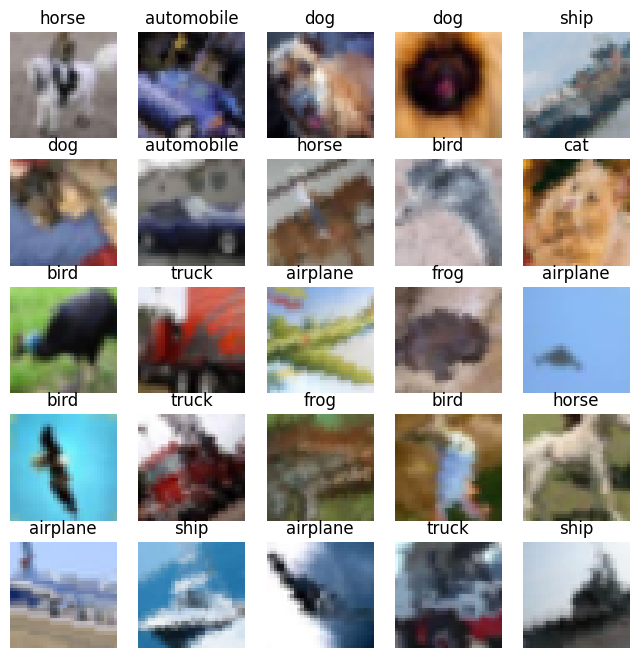

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

In [12]:
## Sample Classification Network

class ConvolutionNeuralNetwork_Task2(torch.nn.Module):
    def __init__(self):
        super(ConvolutionNeuralNetwork_Task2, self).__init__()
        self.conv = torch.nn.Sequential(
          torch.nn.Conv2d(3, 64, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(64, 128, 5),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5)
        )

        self.fc1 = torch.nn.Linear(512, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 10)
  
    def forward(self, data):
        bs = data.shape[0]
#         print(bs)
        data = self.conv(data)
#         print(data.shape)
        data = data.reshape(bs, -1)
#         print(data.shape)
        data = torch.relu(self.fc1(data))
        data = torch.relu(self.fc2(data))
        logits = self.fc3(data)
        return logits

In [13]:
batch_size = 60
train_data = DataLoader(train_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)
test_data = DataLoader(test_dataset, batch_size = batch_size)

In [14]:
# Task 2 Trials
conf_matrix = []

# metrics init
f1_over_trials = []
precision_over_trials = []
recall_over_trials = []

# trials loop
for t in range(5):
    total = 0
    correct = 0
    local_class_acc = []

  # init 
    seed = random.randint(100,10000)
    random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    model2 = ConvolutionNeuralNetwork_Task2().cuda()
    optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum = 0.9)
  
  # Training
    training_loss = []
    validation_loss = []

  # Validation Flag
    val = False

    for epoch in range(60):
#         print(f"Running Trial {t} epoch {epoch}")
        model2.train()
        accuracy = 0.0
        total = 0.0
        correct = 0.0
        train_loss = 0.0
        valid_loss = 0.0
        for i, batch_data in enumerate(train_data):
            data, label_data = batch_data
            data = data.cuda()
            label_data = label_data.cuda()
            predicts = model2(data)
            loss = loss_fn(predicts, label_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        training_loss.append(train_loss / len(train_data))

    if val:
        model2.eval()
        for i, batch_data in enumerate(val_data):
            data, labels = batch_data
            data = data.cuda()
            labels = labels.cuda()

            with torch.no_grad():
                predicts = model2(data)
                loss = loss_fn(predicts, labels)
                valid_loss += loss.item()
                mx_index = torch.argmax(predicts, dim=1)
                total += labels.numel()
                correct += sum(mx_index == labels).item()
        validation_loss.append(valid_loss / len(val_data))
        accuracy = ( correct / total ) * 100
        print(accuracy)

  # Testing
    y_pred = []
    y_true = []
    accuracy = []
    for j, batch_data in enumerate(test_data):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            predicts = model2(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total += labels.numel()
            correct += (max_prob == labels).sum().item()
            y_pred = np.hstack((y_pred, max_prob.cpu()))
            y_true = np.hstack((y_true, labels.cpu()))


    accuracy = ( correct / total ) * 100
    print(f"\n Trial {t} Test Accuracy : {accuracy} \n")
    CM = confusion_matrix(y_true, y_pred)
    conf_matrix.append(CM)

    f1_over_trials.append(f1_score(y_true, y_pred, average=None))
    precision_over_trials.append(precision_score(y_true, y_pred, average=None, zero_division=1))
    recall_over_trials.append(recall_score(y_true, y_pred, average=None))

  # Print metrics
confused_task1 = conf_matrix
classw_acc = classwise_accuracies
print("Classwise f1:")
class_wise(f1_over_trials)
print("\n Classwise precision:")
class_wise(precision_over_trials)
print("\n Classwise recall:")
class_wise(recall_over_trials)
print("\n Confusion Matrix:")
mean_conf_matrix(confused_task1)


 Trial 0 Test Accuracy : 63.029999999999994 


 Trial 1 Test Accuracy : 62.88 


 Trial 2 Test Accuracy : 65.2 


 Trial 3 Test Accuracy : 65.09 


 Trial 4 Test Accuracy : 62.519999999999996 

Classwise f1:
{'airplane': 0.6601371592287145, 'automobile': 0.7651963111967909, 'bird': 0.5327759231375252, 'cat': 0.4241191216092293, 'deer': 0.5979893000068948, 'dog': 0.5555866198793413, 'frog': 0.6832632167433742, 'horse': 0.6871173369309529, 'ship': 0.7184330492904378, 'truck': 0.6503986536720012}

 Classwise precision:
{'airplane': 0.580735938891038, 'automobile': 0.7982885163078673, 'bird': 0.6717997308875256, 'cat': 0.5979793397369116, 'deer': 0.6561484517214764, 'dog': 0.7197045329793692, 'frog': 0.5790548856903021, 'horse': 0.6562286947957514, 'ship': 0.7242614852320195, 'truck': 0.5425008513617875}

 Classwise recall:
{'airplane': 0.7652, 'automobile': 0.7384000000000001, 'bird': 0.4434, 'cat': 0.32999999999999996, 'deer': 0.5508, 'dog': 0.4546, 'frog': 0.8363999999999999, 'horse': 

### In this task: Data Augmentation
1. Added 3 Transformations to the train dataset, no transformations on the test dataset
2. Note that .Compose transforms at runtime, so its like artificially increasing size of samples while not really increaseing the dataset size
3. Changes from previous model: learning_rate = 0.01
4. Summary: Previously trained network on un-augmented dataset performed about 10% better than the augmented model on the same set.

## Task 3: Adversarial Samples

1. Create a Adversarial Test Set by adding a noise sampled from $\sim\mathcal{N}(\mu = 0, \sigma = 0.01)$ to the given Test Set.
2. Compare models obtained in Task 1 and Task 2 on Adversarial Test Set
3. Augment train set by adding noise to samples from train set. (You should have both normal samples and noise added samples in train set)
4. Train your model 5 times with different seeds on noise augmented train set and report results on normal Test Set and Adversarial Test Set 

In [15]:
#--------------------------
# Write your Code Here
#--------------------------

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

batch_size = 1024
train_transform = Compose([
    transforms.RandomRotation(degrees=(15)),
    transforms.CenterCrop(24),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.01)
])

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

test_dataset_normal = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

train_transform_with_noise = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
    AddGaussianNoise(0., 0.01)
])

train_dataset_with_noise = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform_with_noise
)

train_dataset_with_noise = ConcatDataset([train_dataset,train_dataset_with_noise])
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)
test_set = DataLoader(test_dataset_normal, batch_size=batch_size)
# print(len(train_dataset_with_noise))
val_noise_dataset,  train_dataset_with_noise = torch.utils.data.random_split(train_dataset_with_noise, [20000, 80000])
train_data_loader = DataLoader(train_dataset_with_noise, batch_size = batch_size)
val_noise_data_loader = DataLoader(val_noise_dataset, batch_size = batch_size)

# print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [16]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
} 
idx_to_class = {i:c for c, i in class_to_idx.items()} # dict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

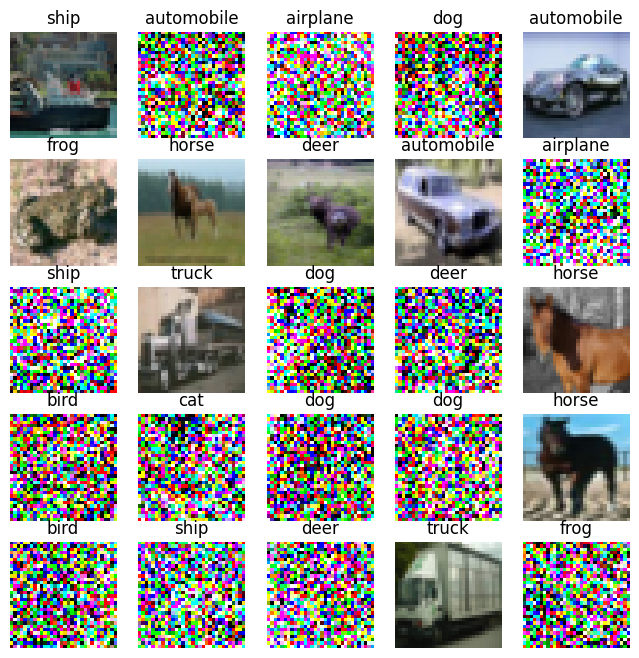

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset_with_noise), size=(1,)).item()
    img, label = train_dataset_with_noise[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

In [18]:
## Sample Classification Network

class ConvolutionNeuralNetwork_Task3(torch.nn.Module):
    def __init__(self):
        super(ConvolutionNeuralNetwork_Task3, self).__init__()
        self.conv = torch.nn.Sequential(
          torch.nn.Conv2d(3, 64, 5),
          torch.nn.ReLU(),
          torch.nn.Conv2d(64, 128, 5),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
          torch.nn.Conv2d(128, 128, [5,5]),
          torch.nn.ReLU(),
#           torch.nn.BatchNorm2d(128),
          torch.nn.MaxPool2d(2,2),
          torch.nn.Dropout(p=0.5)
        )

        self.fc1 = torch.nn.Linear(512, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 10)
  
    def forward(self, data):
        bs = data.shape[0]
#         print(bs)
        data = self.conv(data)
#         print(data.shape)
        data = data.reshape(bs, -1)
#         print(data.shape)
        data = torch.relu(self.fc1(data))
        data = torch.relu(self.fc2(data))
        logits = self.fc3(data)
        return logits

In [30]:
#Compare models
def compare():
#     model1 = ConvolutionNeuralNetwork_Task1().cuda()
#     model2 = ConvolutionNeuralNetwork_Task2().cuda()
#     batch_size = 60
#     loss_fn = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
    total_1 = 0
    correct_1 = 0
    total_2 = 0
    correct_2 = 0
    y_pred_1 = []
    y_pred_2 = []
    y_true_1 = []
    y_true_2 = []
    #model 1 on adv_test_set
    for j, batch_data in enumerate(test_data_loader):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            predicts = model(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total_1 += labels.numel()
            correct_1 += (max_prob == labels).sum().item()
            
            y_pred_1 = np.hstack((y_pred_1, max_prob.cpu()))
            y_true_1 = np.hstack((y_true_1, labels.cpu()))

    accuracy_model_1 = (correct_1 / total_1) * 100
    
    print(f"Model 1 Accuracy : {accuracy_model_1}")
    
    f1_1 = f1_score(y_true_1, y_pred_1, average=None)
    precision_1 = precision_score(y_true_1, y_pred_1, average=None, zero_division=1)
    recall_1 = recall_score(y_true_1, y_pred_1, average=None)
    CM_1 = confusion_matrix(y_true_1, y_pred_1)
    
    #model 2 on adv_test_set
    for j, batch_data in enumerate(test_data_loader):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            predicts = model2(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total_2 += labels.numel()
            correct_2 += (max_prob == labels).sum().item()
            
            y_pred_2 = np.hstack((y_pred_2, max_prob.cpu()))
            y_true_2 = np.hstack((y_true_2, labels.cpu()))
    
    f1_2 = f1_score(y_true_2, y_pred_2, average=None)
    precision_2 = precision_score(y_true_2, y_pred_2, average=None, zero_division=1)
    recall_2 = recall_score(y_true_2, y_pred_2, average=None)
    CM_2 = confusion_matrix(y_true_2, y_pred_2)
    
    accuracy_model_2 = (correct_2 / total_2) * 100
    
    print(f"Model 2 Accuracy : {accuracy_model_2}")
    return f1_1, f1_2, precision_1, precision_2, recall_1, recall_2, CM_1, CM_2

In [31]:
f1_1, f1_2, precision_1, precision_2, recall_1, recall_2, CM_1, CM_2 = compare()

Model 1 Accuracy : 72.3
Model 2 Accuracy : 62.7


In [32]:
def classwise_scores(x):
    i=0
    for c in list(class_to_idx.keys()):
        print(f"{c} : {x[i]}")
        i=i+1

In [34]:
print(f"f1 scores: \n")
print(f"Model 1")
print(f"{classwise_scores(f1_1)}")
print("Model 2")
print(f"{classwise_scores(f1_2)}")
print(f"\n precision scores: \n")
print(f"Model 1")
print(f"{classwise_scores(precision_1)}")
print("Model 2")
print(f"{classwise_scores(precision_2)}")
print(f"\n recall scores: \n")
print(f"Model 1")
print(f"{classwise_scores(recall_1)}")
print("Model 2")
print(f"{classwise_scores(recall_2)}")
print("Model 1: ")
print(f"{CM_1}")
print("Model 2: ")
print(f"{CM_2}")

f1 scores: 

Model 1
airplane : 0.7478349465104432
automobile : 0.8480950024740228
bird : 0.6184701492537314
cat : 0.5284348263714143
deer : 0.6838521400778209
dog : 0.6146445750935329
frog : 0.7895486935866983
horse : 0.7661250615460364
ship : 0.823342175066313
truck : 0.8136293236964377
None
Model 2
airplane : 0.6672436174816098
automobile : 0.7877591312931886
bird : 0.5261890427453341
cat : 0.4061107574793125
deer : 0.5724177726485863
dog : 0.555205047318612
frog : 0.6462686567164178
horse : 0.6755952380952382
ship : 0.6976744186046512
truck : 0.6341659951651893
None

 precision scores: 

Model 1
airplane : 0.7622014537902388
automobile : 0.8393731635651323
bird : 0.5795454545454546
cat : 0.5319148936170213
deer : 0.665719696969697
dog : 0.6601607347876005
frog : 0.7520361990950226
horse : 0.7546071774975752
ship : 0.8768361581920904
truck : 0.8409818569903948
None
Model 2
airplane : 0.5881006864988558
automobile : 0.7777777777777778
bird : 0.6611195158850227
cat : 0.558669001751313

### Model 1 performs better than Model 2.

In [ ]:
# Task 3 Trials
conf_matrix_test_set = []
conf_matrix_noise_test_set = []

# metrics init
f1_over_trials = []
precision_over_trials = []
recall_over_trials = []
f1_over_noise_trials = []
precision_noise_over_trials = []
recall_over_noise_trials = []

# trials loop
for t in range(5):
    total = 0
    correct = 0
    local_class_acc = []

  # init 
    seed = random.randint(100,10000)
    random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    model3 = ConvolutionNeuralNetwork_Task3().cuda()
    optimizer = torch.optim.SGD(model3.parameters(), lr=0.005, momentum = 0.9)
  
  # Training
    training_loss = []
    validation_loss = []

  # Validation Flag
    val = False

    for epoch in range(60):
#         print(f"Running Trial {t} epoch {epoch}")
        model3.train()
        accuracy = 0.0
        total = 0.0
        correct = 0.0
        train_loss = 0.0
        valid_loss = 0.0
        for i, batch_data in enumerate(train_data_loader):
            data, label_data = batch_data
            data = data.cuda()
            label_data = label_data.cuda()
            predicts = model3(data)
            loss = loss_fn(predicts, label_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        training_loss.append(train_loss / len(train_data_loader))

    if val:
        model3.eval()
        for i, batch_data in enumerate(val_noise_data_loader):
            data, labels = batch_data
            data = data.cuda()
            labels = labels.cuda()

            with torch.no_grad():
                predicts = model3(data)
                loss = loss_fn(predicts, labels)
                valid_loss += loss.item()
                mx_index = torch.argmax(predicts, dim=1)
                total += labels.numel()
                correct += sum(mx_index == labels).item()
        validation_loss.append(valid_loss / len(val_noise_data_loader))
        accuracy = ( correct / total ) * 100
        print(accuracy)

  # Testing
    # normal set
    y_pred_test = []
    y_true_test = []
    y_pred_noise_test = []
    y_true_noise_test = []
    accuracy = []
    for j, batch_data in enumerate(test_set):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            predicts = model3(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total += labels.numel()
            correct += (max_prob == labels).sum().item()
            y_pred_test = np.hstack((y_pred_test, max_prob.cpu()))
            y_true_test = np.hstack((y_true_test, labels.cpu()))


    accuracy = ( correct / total ) * 100
    print(f"\n Trial {t} Test Accuracy : {accuracy} \n")
    CM = confusion_matrix(y_true, y_pred)
    conf_matrix_test_set.append(CM)

    f1_over_trials.append(f1_score(y_true_test, y_pred_test, average=None))
    precision_over_trials.append(precision_score(y_true_test, y_pred_test, average=None, zero_division=1))
    recall_over_trials.append(recall_score(y_true_test, y_pred_test, average=None))
    
    # adv test set
    for j, batch_data in enumerate(test_data_loader):
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            predicts = model3(inputs)

            max_prob = torch.argmax(predicts, dim=1)

            total += labels.numel()
            correct += (max_prob == labels).sum().item()
            y_pred_noise_test = np.hstack((y_pred_noise_test, max_prob.cpu()))
            y_true_noise_test = np.hstack((y_true_noise_test, labels.cpu()))


    accuracy = ( correct / total ) * 100
    print(f"\n Trial {t} Test Accuracy : {accuracy} \n")
    CM = confusion_matrix(y_true, y_pred)
    conf_matrix_noise_test_set.append(CM)

    f1_over_noise_trials.append(f1_score(y_true_noise_test, y_pred_noise_test, average=None))
    precision_noise_over_trials.append(precision_score(y_true_noise_test, y_pred_noise_test, average=None, zero_division=1))
    recall_over_noise_trials.append(recall_score(y_true_noise_test, y_pred_noise_test, average=None))

  # Print metrics
confused_task1 = conf_matrix
classw_acc = classwise_accuracies
print("Classwise f1:")
class_wise(f1_over_trials)
print("\n Classwise precision:")
class_wise(precision_over_trials)
print("\n Classwise recall:")
class_wise(recall_over_trials)
print("\n Confusion Matrix:")
mean_conf_matrix(confused_task1)

Trial 0 Test Accuracy : 56.8 

Trial 0 Test Accuracy : 56.865 

### In this task: Adversarial Samples Generation 
1. Added Gaussian Noise using the reference
2. After 2 trials mean accuracy is similar
3. Accuracy degraded by approx 10% compared to model2 and by approx 18% compared to model2

References for Task 3: https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745

General References: Pytorch and SKLearn Docn